In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [ ]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2


In [ ]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [ ]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 160, 160, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 160, 160, 64  256        ['conv2d_42[0][0]']              
 ormalization)                  )                                                           

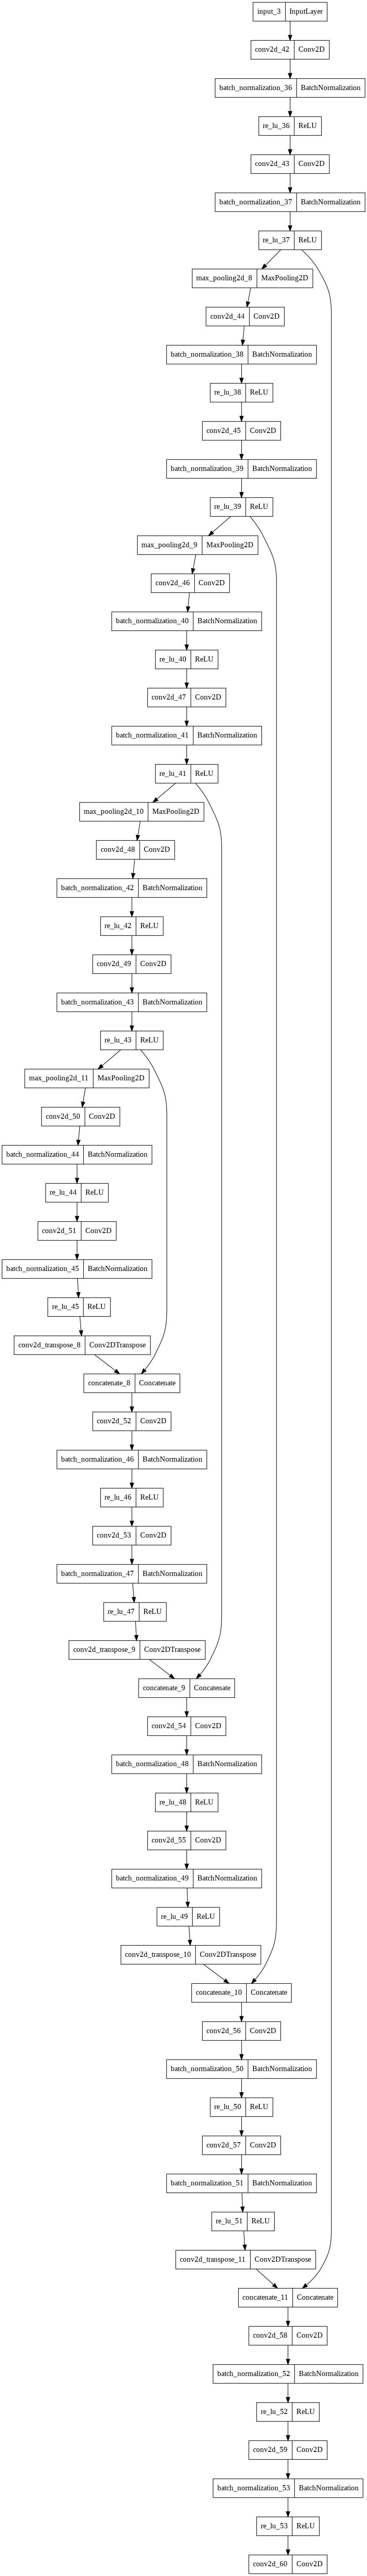

In [ ]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_tar_path = '/content/drive/MyDrive/images.tar.gz'
annotations_tar_path = '/content/drive/MyDrive/annotations.tar.gz'

import tarfile

with tarfile.open(images_tar_path,'r') as tar:
    tar.extractall('/content/drive/MyDrive')

with tarfile.open(annotations_tar_path,'r') as tar:
    tar.extractall('/content/drive/MyDrive')

#if fname.endswith("tar.gz"):
#    tar = tarfile.open(fname, "r:gz")
#    tar.extractall()
#    tar.close()
#elif fname.endswith("tar"):
#    tar = tarfile.open(fname, "r:")
#    tar.extractall()
#    tar.close()

In [ ]:
import os

input_dir = "/content/drive/MyDrive/images/"
target_dir = "/content/drive/MyDrive/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
/content/drive/MyDrive/images/Abyssinian_1.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_1.png
/content/drive/MyDrive/images/Abyssinian_10.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_10.png
/content/drive/MyDrive/images/Abyssinian_100.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_100.png
/content/drive/MyDrive/images/Abyssinian_101.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_101.png
/content/drive/MyDrive/images/Abyssinian_102.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_102.png
/content/drive/MyDrive/images/Abyssinian_103.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_103.png
/content/drive/MyDrive/images/Abyssinian_104.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_104.png
/content/drive/MyDrive/images/Abyssinian_105.jpg | /content/drive/MyDrive/annotations/trimaps/Abyssinian_105.png
/content/drive/MyDrive/images/Abyssinian_106.jpg | /content/drive/MyDrive/anno

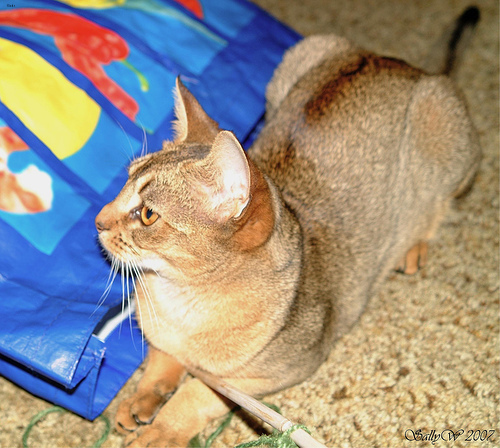

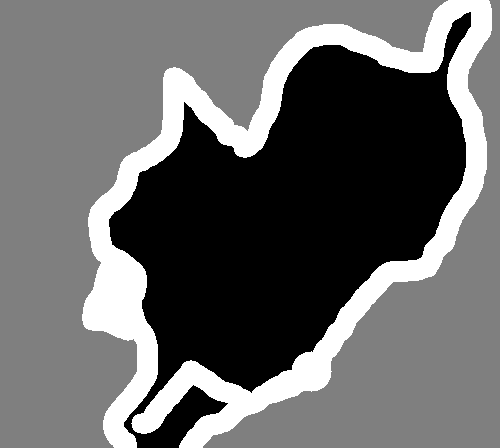

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
798/798 [==============================] - 436s 540ms/step - loss: 0.6239 - val_loss: 0.5285
Epoch 2/15
798/798 [==============================] - 424s 531ms/step - loss: 0.4548 - val_loss: 0.4546
Epoch 3/15
798/798 [==============================] - 424s 531ms/step - loss: 0.3848 - val_loss: 0.4244
Epoch 4/15
798/798 [==============================] - 424s 531ms/step - loss: 0.3469 - val_loss: 0.3370
Epoch 5/15
798/798 [==============================] - 423s 530ms/step - loss: 0.3193 - val_loss: 0.3451
Epoch 6/15
798/798 [==============================] - 422s 529ms/step - loss: 0.2981 - val_loss: 0.3648
Epoch 7/15
798/798 [==============================] - 423s 530ms/step - loss: 0.2788 - val_loss: 0.2999
Epoch 8/15
798/798 [==============================] - 423s 530ms/step - loss: 0.2649 - val_loss: 0.3150
Epoch 9/15
798/798 [==============================] - 423s 530ms/step - loss: 0.2482 - val_loss: 0.3072
Epoch 10/15
798/798 [==============================] - 423s 529m

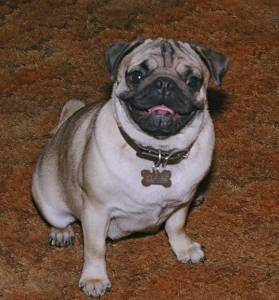

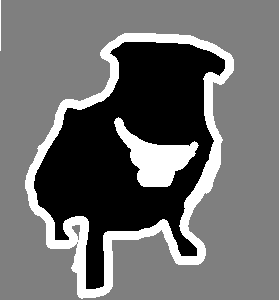

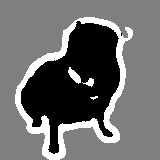

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.